# DA9 Preprocess
12/19/2023

In [72]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/afink_lfp_pipeline/LFPAnalysis/')


In [74]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [75]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA9'
subj_format = ['nlx']
subj_site = ['UCD']


# Make mne_data

### Get NLX File Information


In [5]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [6]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [7]:
seeg_names = [x.lower() for x in seeg_names] 

In [8]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [9]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}') #this output should tell you what your photodiode name is

Unidentified data type in Photodiode


In [10]:
ch_name

['RIL7',
 'RIL6',
 'LAD1',
 'RFP8',
 'RFP9',
 'LHD8',
 'LHD9',
 'RHD1',
 'LHD2',
 'LHD3',
 'RFP2',
 'RFP3',
 'LFP1',
 'LHD5',
 'LHD4',
 'RHD7',
 'RHD6',
 'LFP7',
 'LFP6',
 'Photodiode',
 'RFP5',
 'RFP4',
 'RIL1',
 'LAD7',
 'LAD6',
 'RHD3',
 'RHD2',
 'LHD1',
 'RFP1',
 'LFP3',
 'LFP2',
 'LFP9',
 'LFP8',
 'RHD9',
 'RHD8',
 'LAD8',
 'RIL4',
 'RIL5',
 'LAD3',
 'LAD2',
 'RIL8',
 'RIL3',
 'RIL2',
 'LAD4',
 'LAD5',
 'LHD6',
 'LHD7',
 'RHD4',
 'RHD5',
 'LFP4',
 'LFP5',
 'RFP6',
 'RFP7']

In [11]:
srs

[4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 32000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000]

### Load and resample data

In [12]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [13]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


In [14]:
### make sure timing is aligned post resampling --- check this 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [15]:
mne_data_resampled[0]

<RawArray | 52 x 7200008 (14400.0 s), ~2.79 GB, data loaded>

In [16]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
mne_data.add_channels([mne_data_resampled[1]])
mne_data

<RawArray | 53 x 7200008 (14400.0 s), ~2.84 GB, data loaded>

In [17]:
#make channel names lowercase 
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 53 x 7200008 (14400.0 s), ~2.84 GB, data loaded>

### Photodiode
- examine photodiode 
- save out before resampling/notch filtering *unless nlx - then you have to resample first 

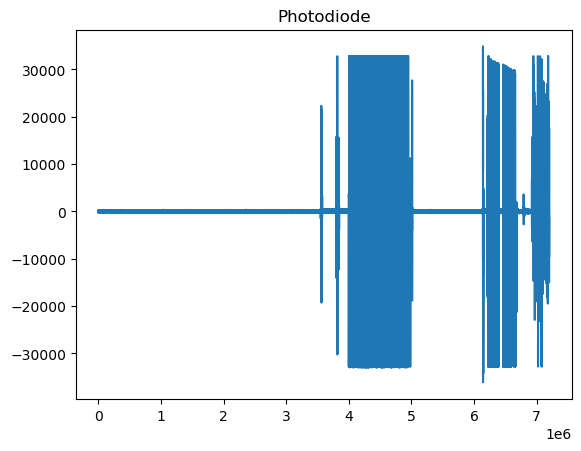

In [18]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('photodiode')
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [19]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='photodiode', overwrite=True)

In [20]:
mne_data.drop_channels(['photodiode'])

<RawArray | 52 x 7200008 (14400.0 s), ~2.79 GB, data loaded>

### Notch filter line noise

In [31]:

mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    6.6s finished


<RawArray | 52 x 7200008 (14400.0 s), ~2.79 GB, data loaded>

### Anatomical Localization 

In [32]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAD1,mAmyg_L,-17.471760,10.790956,-9.888621,-14.202810,-3.822049,-19.553816,Gray,Left Amygdala,Amygdala (SF),L ParaHippocampal Gyrus,L Amyg,Left parahippocampal gyrus A,NaN
1,LAD2,mAmyg_L,-22.261112,10.391291,-9.089589,-19.216283,-3.891958,-19.043659,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
2,LAD3,mAmyg_L,-27.449577,10.391291,-8.690073,-24.550816,-3.667518,-19.122501,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
3,LAD4,lAmyg_L,-32.238930,9.991626,-8.290558,-29.505896,-3.881665,-19.126831,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
4,LAD5,Unknown,-37.427395,9.591962,-7.491526,-34.980580,-3.964504,-18.722788,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
5,LAD6,A38l_L,-42.216747,9.192297,-7.092010,-40.067985,-4.078986,-18.697161,Gray,Left PP planum polare,Area Id1,Unknown,L STG,Left superior temporal gyrus A,NaN
6,LAD7,A22r_L,-47.405212,8.792632,-6.292979,-45.629547,-4.036446,-18.194110,Gray,Left Cerebral White Matter,Unknown,L Middle Temporal Gyrus,L STG,Left superior temporal gyrus B,NaN
7,LAD8,aSTS_L,-52.194565,8.792632,-5.493947,-50.795900,-3.681195,-17.772288,Gray,Left STG superior temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior temporal gyrus B,NaN
8,LFP1,A11m_L,-19.068211,44.362791,-1.498790,-13.605498,34.223324,-16.416872,White,Left Cerebral White Matter,Area Fo1,L Rectal Gyrus,L OrG,Unknown,WM
9,LFP2,Unknown,-19.866436,42.364467,2.895883,-15.002357,33.627828,-10.932631,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM


In [33]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

[]


In [34]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)




Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [35]:
unmatched_seeg

[]

In [36]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 26 left sEEG and 26 right sEEG electrodes
We have a total of 52 sEEG electrodes


In [37]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawArray | 52 x 7200008 (14400.0 s), ~2.79 GB, data loaded>

In [38]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 52 x 7200008 (14400.0 s), ~2.79 GB, data loaded>

## Signal Cleaning 
Methods:
- Remove all channels that are obviously noise
- Be LIBERAL with bad labeling - these channels are NOT removed from the dataset, they are just NOT USED to rereference other channels. 
- This process is iterative depending on how TFRs look. 

In [86]:
#automatic detection - not stringent enough usually
# bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
# mne_data.info['bads'] = bads
# bads

['lhd9', 'ril7']

In [39]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [40]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [41]:
probe_ch_counts

{'lad': 8,
 'lfp': 9,
 'lhd': 9,
 'rfp': 9,
 'rhd': 9,
 'ril': 8,
 'ulfp': 1,
 'ulhd': 1,
 'urfp': 1,
 'urhd': 1}

<IPython.core.display.Javascript object>


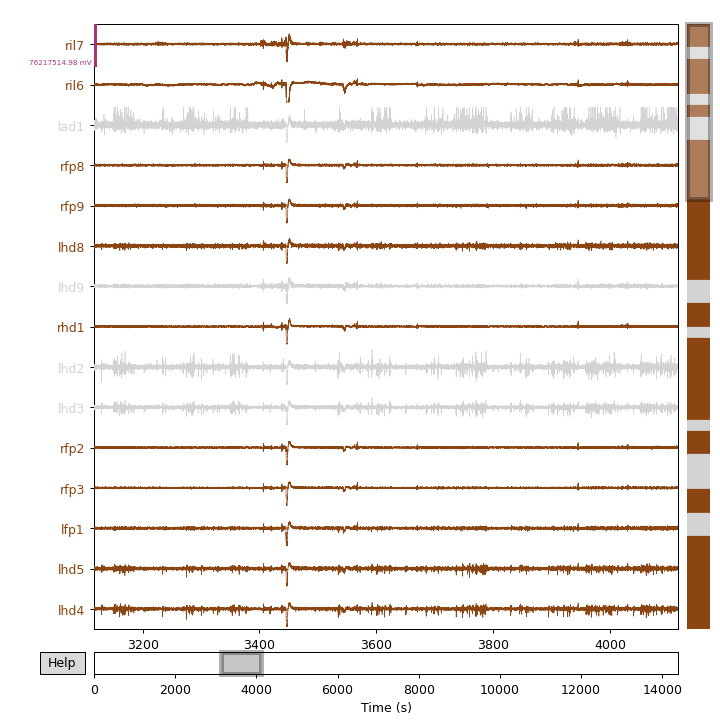

<IPython.core.display.Javascript object>


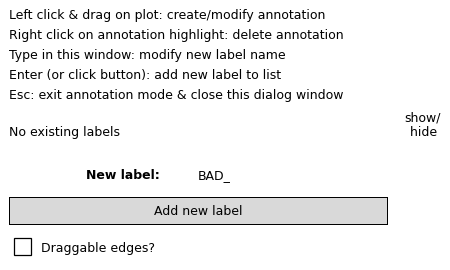

In [91]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=1000, n_channels=15, scalings=mne_data._data.max())
fig.fake_keypress('a')

In [42]:
##save info in SWB_electrode_info spreadsheet!
mne_data.info['bads']
mne_data.info['bads'] =['lad7',
 'lad6',
 'lad1',
 'lhd2',
 'lhd3',
 'lhd9',
 'lhd1',
 'lad3',
 'lad8',
 'lad2',
 'lad4',
 'lad5',
 'ril8']

In [43]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 13 items (lad7, lad6, lad1, lhd2, lhd3, lhd9, lhd1, lad3, lad8, ...)
 ch_names: ril7, ril6, lad1, rfp8, rfp9, lhd8, lhd9, rhd1, lhd2, lhd3, ...
 chs: 52 sEEG
 custom_ref_applied: False
 dig: 52 items (52 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 52
 projs: []
 sfreq: 500.0 Hz
>

# Re-referencing 
- wm reref
- bipolar reref

In [146]:
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### WM Re-ref

In [175]:
# Re-reference neural data
mne_data_wm_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='wm', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [176]:
mne_data_wm_reref

<Raw | raw_ieeg.fif, 28 x 7200008 (14400.0 s), ~1.50 GB, data loaded>

In [177]:
mne_data_wm_reref.ch_names

['lad1-lfp1',
 'lad2-lfp4',
 'lad3-lfp4',
 'lad4-lfp4',
 'lad5-lfp4',
 'lad6-lfp4',
 'lad7-lfp4',
 'lad8-lfp4',
 'lfp8-lfp9',
 'lhd1-lfp4',
 'lhd2-lfp4',
 'lhd3-lfp4',
 'lhd4-lfp4',
 'lhd5-lfp6',
 'lhd6-lfp6',
 'lhd7-lfp6',
 'lhd8-lfp6',
 'rhd1-rfp3',
 'rhd2-rfp6',
 'rhd3-rfp6',
 'rhd4-rfp7',
 'rhd5-rfp8',
 'rhd6-rfp8',
 'rhd7-rfp9',
 'ril1-rfp2',
 'ril2-rfp6',
 'ril3-rfp6',
 'ril4-rfp7']

In [178]:
mne_data_wm_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)

### Bipolar Re-ref

In [147]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [148]:
mne_data_bp_reref.ch_names

['lfp7-lfp8',
 'lfp8-lfp9',
 'lhd4-lhd5',
 'lhd5-lhd6',
 'lhd6-lhd7',
 'lhd7-lhd8',
 'rhd1-rhd2',
 'rhd2-rhd3',
 'rhd3-rhd4',
 'rhd4-rhd5',
 'rhd5-rhd6',
 'rhd6-rhd7',
 'ril1-ril2',
 'ril2-ril3',
 'ril3-ril4']

In [149]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 15 x 7200008 (14400.0 s), ~824.0 MB, data loaded>

In [150]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

### Save mne data 

In [99]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True) #this now contains oob channels as 'bads'

# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [100]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref, mne_data_wm_reref

In [101]:
#add directory for TFRs
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
tfr_dir = f'{base_dir}/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
#load behavior data
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)


### Photodiode Alignment

In [102]:
### Photodiode alignment

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=1)

30 blocks
..............................

found matches for 60 of 459 pulses
22 blocks
......................

found matches for 20 of 459 pulses


In [103]:
print(slope,offset)

0.9807423538824177 7367.509531147343


## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [179]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [180]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [181]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [182]:
### Epoch WM reref data for now 
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
#     ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   11.4s finished


In [183]:
epochs_all_evs 

{'TrialOnset': <Epochs |  149 events (all good), -2 - 1 sec, baseline off, ~47.8 MB, data loaded, with metadata,
  'TrialOnset': 149>,
 'DecisionOnset': <Epochs |  149 events (all good), -1 - 6 sec, baseline off, ~111.5 MB, data loaded, with metadata,
  'DecisionOnset': 149>}

### Add behavioral data to metadata 

In [184]:
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,45.0,mix,458.262575,458.273875,462.041225,462.049006,3.767350,0.0,-1.10,...,1.10,1.10,0.00,0.0,1.10,1.10,-1.10,-1.10,0.000,0.00
1,2,146.0,loss,468.814804,468.828686,473.819151,473.826753,4.990465,-0.6,-1.68,...,-0.60,-0.60,-0.60,-0.6,0.00,0.00,0.00,0.00,0.000,0.00
2,3,140.0,loss,480.509956,480.510710,484.830998,484.838941,4.320288,-0.5,-2.50,...,2.00,2.00,0.00,0.0,2.00,2.00,-2.50,-2.50,0.000,0.00
3,4,57.0,gain,497.135665,497.142355,500.407262,502.416627,3.264907,0.2,0.00,...,0.63,0.43,0.00,0.0,0.63,0.43,0.00,0.20,0.315,0.00
4,5,47.0,mix,507.397588,507.406724,511.335869,511.343683,3.929145,0.0,-1.10,...,1.10,1.10,0.00,0.0,1.10,1.10,-1.10,-1.10,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,127.0,loss,2211.392241,2211.392976,2214.280426,2214.288188,2.887450,-0.4,-1.26,...,-0.40,-0.40,-0.40,-0.4,0.00,0.00,0.00,0.00,0.000,0.00
146,147,78.0,gain,2220.904660,2220.905430,2225.208157,2227.218260,4.302726,0.4,0.00,...,-1.44,-0.40,-1.44,-0.4,0.00,0.00,1.44,0.40,0.000,-0.72
147,148,85.0,gain,2236.130865,2236.138261,2238.452797,2240.478945,2.314536,0.5,0.00,...,1.24,0.74,0.00,0.0,1.24,0.74,0.00,0.50,0.620,0.00
148,149,148.0,loss,2245.193557,2245.194353,2247.982401,2247.990169,2.788048,-0.6,-2.16,...,1.56,1.56,0.00,0.0,1.56,1.56,-2.16,-2.16,0.000,0.00


In [185]:
behav_params = ['SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
                'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
                'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
                'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE','nRPE']

In [186]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [187]:
epochs_all_evs[event].metadata

,lad1-lfp1,lad2-lfp4,lad3-lfp4,lad4-lfp4,lad5-lfp4,lad6-lfp4,lad7-lfp4,lad8-lfp4,lfp8-lfp9,lhd1-lfp4,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.10,1.10,0.00,0.0,1.10,1.10,-1.10,-1.10,0.000,0.00
1,[7834.178],NaN,NaN,[7834.222],[7834.224],NaN,NaN,NaN,NaN,NaN,...,-0.60,-0.60,-0.60,-0.6,0.00,0.00,0.00,0.00,0.000,0.00
2,NaN,[7845.06],[7845.064],[7845.06],NaN,NaN,NaN,NaN,NaN,NaN,...,2.00,2.00,0.00,0.0,2.00,2.00,-2.50,-2.50,0.000,0.00
3,"[7859.522, 7863.208]",[7859.722],[7859.726],[7859.724],NaN,NaN,NaN,NaN,NaN,NaN,...,0.63,0.43,0.00,0.0,0.63,0.43,0.00,0.20,0.315,0.00
4,[7870.236],[7870.24],[7870.244],[7870.246],NaN,NaN,NaN,NaN,NaN,NaN,...,1.10,1.10,0.00,0.0,1.10,1.10,-1.10,-1.10,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.40,-0.40,-0.40,-0.4,0.00,0.00,0.00,0.00,0.000,0.00
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.44,-0.40,-1.44,-0.4,0.00,0.00,1.44,0.40,0.000,-0.72
146,[9567.776],[9567.782],[9567.784],[9567.786],NaN,NaN,NaN,NaN,NaN,NaN,...,1.24,0.74,0.00,0.0,1.24,0.74,0.00,0.50,0.620,0.00
147,"[9572.952, 9575.908]","[9573.102, 9575.908]","[9573.104, 9575.916]","[9573.112, 9575.92]","[9573.11, 9575.924]",[9575.924],NaN,NaN,NaN,NaN,...,1.56,1.56,0.00,0.0,1.56,1.56,-2.16,-2.16,0.000,0.00


### Save raw epoched data 

In [188]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/wm_epoch_{event}.fif', overwrite=True)
#     epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

### Baseline + Decompose into TFRs

In [189]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [190]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [191]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [192]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


In [193]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 28, ~478.5 MB>}

In [194]:
power_epochs = {}

In [195]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=True, ## make sure this is true!
                                                  baseline_only=False)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



In [197]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 28, ~2.33 GB>

In [198]:
#conda install -c conda-forge h5io must install to save tfr data
# power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/wm_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [199]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir
date = '01082024' #add date to file name 


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_wmref.png', format='png', metadata=None,
#     plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()
